In [1]:
#Paquetes para modelos
import sciann as sn
import numpy as np
from sciann.utils.math import diff, sign, sin, exp
from sciann.utils import math as scmath

#Paquetes para gráficos

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

---------------------- SCIANN 0.5.5.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



# Ecuación  de la Placa

#### Variables de la ecuación

In [2]:
x = sn.Variable("x") 
y = sn.Variable('y')
t = sn.Variable('t')
u = sn.Functional("u", [x,y,t], 5*[5] ,"tanh")

In [3]:
#Función de activación para los bordes

def activacion(coord,location,direction):
    return (1-sign(direction*(location-coord)))/2

#### Constantes

In [4]:
TOL = 0.05 # Esta constante se usa para que los bordes tomen valores y se activen las funciones de contorno
conveccion = 25. # Coeficiente de pérdida de calor en los bordes y=1 e y=-1
conductividad = .5 # Capacidad conductora de calor del material de la placa
capCal = 1. # Capacidad de retención de calor del material de la placa
focoTemp = 10. # Temperatura del foco de calor
tempExt = 5. # Temperatura del exterior
tempInicial = 0. # Temperatura inicial de la placa

#### Mallado de la Placa

In [5]:
denspt = 15 # Densidad de puntos de evaluación de los funcionales
xmin,ymin,xmax,ymax=-2,-2,2,2 # Límites en x e y
tmin,tmax=0,5 # Límites en tiempo t
xrange,yrange=xmax-xmin,ymax-ymin
trange=tmax-tmin

# Mallado (es una malla en tres dimensiones)
x_data, y_data, t_data = np.meshgrid(
    np.linspace(xmin, xmax, xrange*denspt), 
    np.linspace(ymin, ymax, yrange*denspt),
    np.linspace(tmin,tmax,trange*denspt)
)

x_data = x_data.flatten()[:,None]
y_data = y_data.flatten()[:,None]
t_data = t_data.flatten()[:,None]

#Número de puntos
x_data.shape

(270000, 1)

#### Ecuación del calor

In [6]:
#Este funcional explica el flujo del calor a lo largo de la placa (2 dimensiones)
L1 = sn.constraints.PDE(capCal*diff(u,t) - conductividad *( (diff(u,x,order=2) + diff(u,y,order=2))))

#### Otras ecuaciones

In [7]:
# Este funcional es la condición de que la temperatura inicial sea tempInicial
T0 = sn.constraints.PDE( activacion(t,TOL,-1)*(u-(focoTemp * exp(-(x**2+y**2)/(2*(0.1)**2))/(2*np.pi*0.1*0.1))))

#Estos dos funcionales describen la pérdida de calor en los bordes superior e inferior
L2 = (1-sign(1*(2-TOL-y)))/2 *(  u-tempExt)
L3 = (1-sign(-1*(-2+TOL-y)))/2 *(u-tempExt)

#Estos dos funcionales describen el aislamiento (pérdida de calor nula) en los bordes laterales
L4 = sn.constraints.PDE((activacion(x,2-TOL,1)*conductividad*(  diff(u,x))))
L5 = sn.constraints.PDE((activacion(x,-2+TOL,-1)*conductividad*(- diff(u,x))))

#Este funcional describe el flujo del calor a través de la placa, incluyendo el foco de calor en este caso
# F1 = L1 - activacion(t,0.5,1)*(focoTemp * exp(-(x**2+y**2)/(2*(0.5)**2))/(2*np.pi*0.5*0.5))

#### Datos introducidos como puntos

In [8]:
#Indices de t<TOL
indInicio = np.where(t_data <= TOL)[0]
#Temperaturas de t<TOL
calorInicio = np.zeros(len(indInicio),float)

#Indices del foco central
radio = np.sqrt(x_data[:,0]**2+y_data[:,0]**2)
indCentro = np.where(radio<0.3)[0]
indT_desde_05 = np.where(t_data[:,0]>0.5)[0]
indT_hasta_15 = np.where(t_data[:,0]<1.5)[0]
indT = np.intersect1d(indT_desde_05,indT_hasta_15)
indCentro = np.intersect1d(indCentro,indT)
calorCentro = focoTemp * np.exp(-(x_data[indCentro,0]**2+y_data[indCentro,0]**2)/(2*(0.3)**2))/(2*np.pi*0.3*0.3)

#Indices de los bordes y=1 e y=-1
indBordes = np.where(np.abs(y_data)>=1.95)[0]
indBordes = np.intersect1d(indBordes,np.where(t_data[:,0]>TOL)[0])
calorBordes = np.full(len(indBordes),tempExt)


#Juntamos los índices y los datos y los ponemos en el formato que Sciann necesita:

indices = np.concatenate((indInicio,indBordes,indCentro))[:,None]
datos = np.concatenate((calorInicio,calorBordes,calorCentro))[:,None]

#Definimos el funcional u
d1 = sn.constraints.Data(u)

#### Gráficas de los puntos

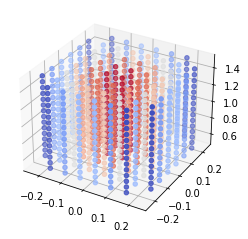

In [9]:
fig=plt.figure()
ax = fig.gca(projection='3d')

ax.scatter3D(x_data[indCentro,0],y_data[indCentro,0],t_data[indCentro,0],c=calorCentro,cmap=cm.coolwarm)

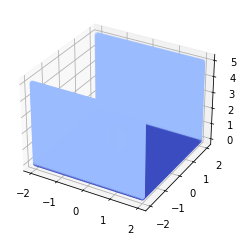

In [10]:
fig=plt.figure()
ax = fig.gca(projection='3d')

ax.scatter3D(x_data[indices,0],y_data[indices,0],t_data[indices,0],c=datos,cmap=cm.coolwarm)

# Construcción del modelo

In [11]:
m = sn.SciModel ([x,y,t], [d1,L1,L4,L5],"mse","Adam")

#### Entrenamiento del modelo

In [ ]:
history = m.train([x_data, y_data, t_data], [(indices,datos)]+3*['zeros'], epochs =1000,verbose=0,stop_loss_value=0.01,
                  batch_size=15000)

In [29]:
 print((history.history['loss'][0:10],history.history['loss'][-1]))

([6.427338229285346, 6.427920791837904, 6.4277328385247126, 6.443286286460029, 6.4366410043504505, 6.435639725791083, 6.419124709235297, 6.420902490615845, 6.417733775244819, 6.4274599817064075], 6.2892452875773115)


# Gráficos del modelo resultante

#### Mallado para test

In [14]:
densptTest = 10 # Densidad de puntos de evaluación de los funcionales
xminT,yminT,xmaxT,ymaxT=-2,-2,2,2 # Límites en x e y
tminT,tmaxT=0,6 # Límites en tiempo t
xrangeT,yrangeT=xmaxT-xminT,ymaxT-yminT
trangeT=tmaxT-tminT


x_test, y_test, t_test = np.meshgrid(
    np.linspace(xminT, xmaxT, xrangeT*densptTest*10), 
    np.linspace(yminT, ymaxT, yrangeT*densptTest*10),
    np.linspace(tminT,tmaxT,trangeT*densptTest*10)
)


u_pred = u.eval(m,[x_test,y_test,t_test])


#### Gráfico en 2D coloreado

<ipython-input-15-1df07156bc2f>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_test[:,:,1], y_test[:,:,1], u_pred[:,:,round((tiempoMostrado-tmin)*densptTest*10)],


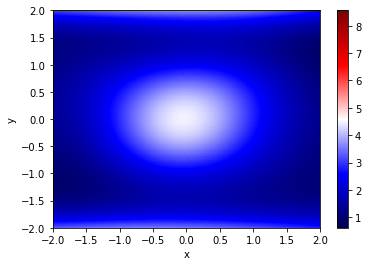

In [15]:
tiempoMostrado = 0.1 #Aquí se elige el segundo a mostrar

fig=plt.plot()
plt.pcolor(x_test[:,:,1], y_test[:,:,1], u_pred[:,:,round((tiempoMostrado-tmin)*densptTest*10)], 
           cmap='seismic',vmin=u_pred.min(),vmax=u_pred.max())
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

#### Gráfico en 3D coloreado

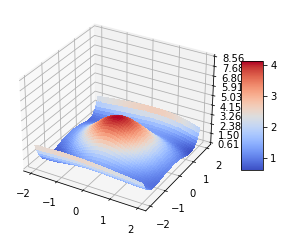

In [27]:
tiempoMostrado = 0 #Aquí se elige el segundo a mostrar

fig=plt.figure()
ax = fig.gca(projection='3d')

X = x_test[:,:,0]
Y = y_test[:,:,0]
Z = u_pred[:,:,round((tiempoMostrado-tmin)*densptTest*10)]


surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False )

# Customize the z axis.
ax.set_zlim(u_pred.min(), u_pred.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

#### Gráfica de la temperatura en un punto a lo largo de t

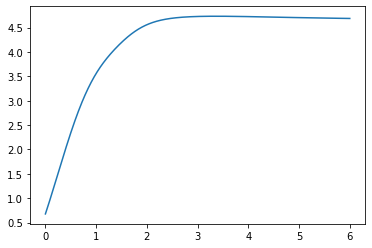

In [17]:
#Índices del punto a mostrar
x_cell = 100
y_cell = 10 


plt.plot(t_test[x_cell,y_cell],u_pred[x_cell,y_cell])